In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Preprocesamiento y modelos
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [4]:
import optuna

In [5]:
df = pd.read_excel("../DATA/DataHackathon.xlsx")

In [6]:
df.head()

,Orden de Venta,Creacion Orden de Venta,Codigo Cliente,Articulo,Cantidad,Unidad de venta
0,ABC063830,2021-01-04,F26E901B,IVP11576,60,L
1,ABC063832,2021-01-04,12558C43,IVP07229,540,KG
2,ABC063833,2021-01-04,A760F354,IVP04039,3,PZA
3,ABC063834,2021-01-04,A760F354,IVP04039,4,PZA
4,ABC063835,2021-01-04,A760F354,IVP01010,1,PZA


In [7]:
# Filtrar solo los 100 artículos TOP (los que hacen el 90% de las órdenes)
articulos_top = df['Articulo'].value_counts().head(100).index.tolist()
df_top = df[df['Articulo'].isin(articulos_top)].copy()

In [8]:
df_top.head()

,Orden de Venta,Creacion Orden de Venta,Codigo Cliente,Articulo,Cantidad,Unidad de venta
0,ABC063830,2021-01-04,F26E901B,IVP11576,60,L
1,ABC063832,2021-01-04,12558C43,IVP07229,540,KG
2,ABC063833,2021-01-04,A760F354,IVP04039,3,PZA
3,ABC063834,2021-01-04,A760F354,IVP04039,4,PZA
5,ABC063836,2021-01-04,A760F354,IVP04039,4,PZA


In [9]:
# ===========================
# 2. Preprocesamiento
# ===========================
le_articulo = LabelEncoder()
df_top['Articulo_encoded'] = le_articulo.fit_transform(df_top['Articulo'])

In [10]:
# Features temporales
df_top['Mes'] = df_top['Creacion Orden de Venta'].dt.month
df_top['Dia'] = df_top['Creacion Orden de Venta'].dt.day
df_top['Dia_Semana'] = df_top['Creacion Orden de Venta'].dt.dayofweek

In [11]:
# Normalizamos la cantidad
scaler = MinMaxScaler()
df_top['Cantidad_scaled'] = scaler.fit_transform(df_top[['Cantidad']])

In [51]:
# ===========================
# 3. Función para generar secuencias
# ===========================
def crear_secuencias(df, articulo_id, sequence_length=1015):
    df_art = df[df['Articulo_encoded'] == articulo_id].sort_values('Creacion Orden de Venta')
    sequences, features, targets = [], [], []
    
    data_qty = df_art['Cantidad_scaled'].values
    data_dates = df_art[['Mes', 'Dia', 'Dia_Semana']].values
    
    if len(data_qty) < sequence_length:
        return None, None, None

    for i in range(len(data_qty) - sequence_length):
        seq_qty = data_qty[i:i+sequence_length]
        seq_date = data_dates[i+sequence_length]
        seq_target = data_qty[i+sequence_length]
        
        sequences.append(seq_qty)
        features.append(seq_date)
        targets.append(seq_target)
        
    articulo_array = np.full((len(sequences), 1), articulo_id)
    
    return [np.array(sequences), np.array(features), articulo_array], np.array(targets)

In [52]:
# ===========================
# 4. Crear el modelo LSTM mejorado
# ===========================
def crear_modelo(sequence_length, num_articulos, embedding_size=8, lstm_units=64, dropout_rate=0.2):
    # Entradas
    input_qty = Input(shape=(sequence_length,))
    input_fecha = Input(shape=(3,))
    input_articulo = Input(shape=(1,))
    
    # Embedding artículo
    articulo_emb = Embedding(input_dim=num_articulos, output_dim=embedding_size)(input_articulo)
    articulo_emb_flat = tf.keras.layers.Flatten()(articulo_emb)
    
    # LSTM secuencia cantidades
    x_qty = tf.keras.layers.Reshape((sequence_length, 1))(input_qty)
    lstm_out = LSTM(lstm_units)(x_qty)
    
    # Concatenar todo
    concat = Concatenate()([lstm_out, articulo_emb_flat, input_fecha])
    
    dense1 = Dense(64, activation='relu')(concat)
    drop1 = Dropout(dropout_rate)(dense1)
    output = Dense(1, activation='linear')(drop1)
    
    model = Model(inputs=[input_qty, input_fecha, input_articulo], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [53]:
# ===========================
# 5. Optimización de hiperparámetros con Optuna
# ===========================
def objective(trial):
    embedding_size = trial.suggest_int('embedding_size', 4, 16)
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    sequence_length = trial.suggest_int('sequence_length', 30, 90)
    
    X, y = crear_secuencias(df_top, articulo_id=0, sequence_length=sequence_length)
    if X is None:
        return float('inf')
    
    model = crear_modelo(sequence_length, num_articulos=100, embedding_size=embedding_size, lstm_units=lstm_units, dropout_rate=dropout_rate)
    
    history = model.fit(X, y, epochs=10, batch_size=16, verbose=0)
    
    loss = history.history['loss'][-1]
    return loss

In [54]:
best_params = {
    'embedding_size': 8,
    'lstm_units': 64,
    'dropout_rate': 0.2,
    'sequence_length': 60
}

model = crear_modelo(best_params['sequence_length'], num_articulos=100, 
                     embedding_size=best_params['embedding_size'], 
                     lstm_units=best_params['lstm_units'], 
                     dropout_rate=best_params['dropout_rate'])



In [55]:
# ===========================
# 7. Seleccionar el artículo por nombre
# ===========================
articulo_nombre = "IVP11576"  # Cambia aquí el nombre del artículo que quieras analizar
articulo_id = le_articulo.transform([articulo_nombre])[0]

# Entrenamiento del modelo sobre el artículo seleccionado
X, y = crear_secuencias(df_top, articulo_id=articulo_id, sequence_length=best_params['sequence_length'])
model.fit(X, y, epochs=30, batch_size=16, validation_split=0.2, callbacks=[
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
])


Epoch 1/30


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.2625 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5089 - val_loss: 0.0455 - learning_rate: 0.0010
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2868 - val_loss: 0.0472 - learning_rate: 0.0010
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3823 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2483 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8329 - val_loss: 0.0384 - learning_rate: 1.0000e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7430 - val_loss: 0.0168 - learning_rate: 1.0000e-04
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7199 - val_loss: 0.0151 - learning_rate: 1.0000e-04
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7386 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━

In [56]:
# ===========================
# 8. Métricas de evaluación
# ===========================
predicciones_train = model.predict(X)
mae_train = mean_absolute_error(y, predicciones_train)
mse_train = mean_squared_error(y, predicciones_train)
print(f"MAE del entrenamiento: {mae_train:.4f}, MSE del entrenamiento: {mse_train:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE del entrenamiento: 0.1284, MSE del entrenamiento: 0.0283


In [57]:
# ===========================
# 9. Predicción del siguiente mes (31 días)
# ===========================
ultima_secuencia = X[0][-1].reshape(1, best_params['sequence_length'])
fecha_base = df_top[df_top['Articulo_encoded'] == articulo_id]['Creacion Orden de Venta'].max()

predicciones_futuras = []

for i in range(31):
    mes = (fecha_base + pd.Timedelta(days=i+1)).month
    dia = (fecha_base + pd.Timedelta(days=i+1)).day
    dia_semana = (fecha_base + pd.Timedelta(days=i+1)).dayofweek
    
    input_fecha = np.array([[mes, dia, dia_semana]])
    input_articulo = np.array([[articulo_id]])
    
    pred = model.predict([ultima_secuencia, input_fecha, input_articulo])
    predicciones_futuras.append(pred[0][0])
    
    # Actualizar la secuencia para el próximo día
    nueva_secuencia = np.append(ultima_secuencia.flatten()[1:], pred[0][0])
    ultima_secuencia = nueva_secuencia.reshape(1, best_params['sequence_length'])

# Desnormalizar
predicciones_futuras = scaler.inverse_transform(np.array(predicciones_futuras).reshape(-1, 1))




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

In [58]:
# ===========================
# 10. Cantidad total predicha para el próximo mes
# ===========================
cantidad_total_mes = np.sum(predicciones_futuras)
print(f"Cantidad total predicha para el próximo mes ({articulo_nombre}): {cantidad_total_mes:.2f} unidades")

Cantidad total predicha para el próximo mes (IVP11576): 10912.59 unidades


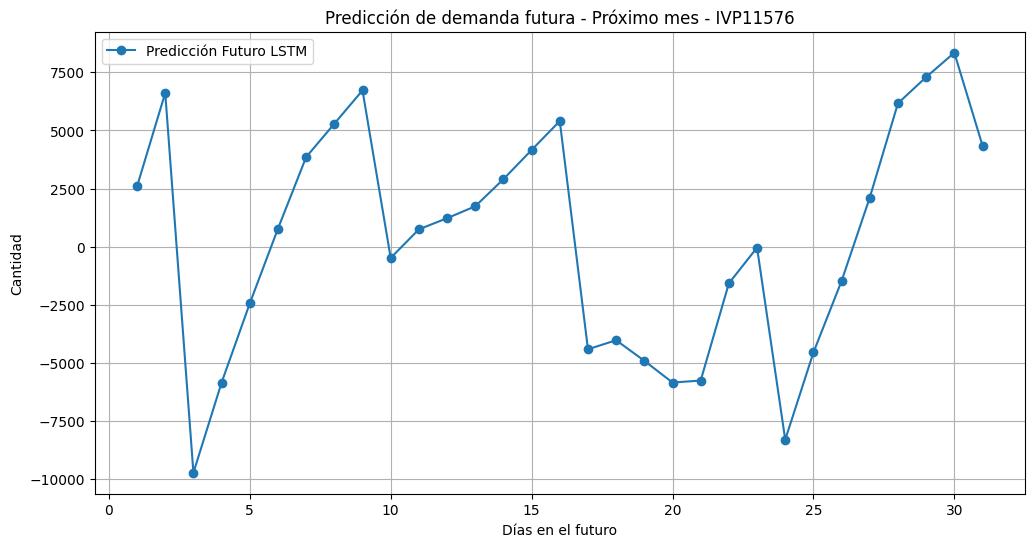

In [59]:
# ===========================
# 11. Gráfica de predicciones futuras
# ===========================
plt.figure(figsize=(12, 6))
plt.plot(range(1, 32), predicciones_futuras, marker='o', label='Predicción Futuro LSTM')
plt.title(f'Predicción de demanda futura - Próximo mes - {articulo_nombre}')
plt.xlabel('Días en el futuro')
plt.ylabel('Cantidad')
plt.legend()
plt.grid(True)
plt.show()
